In [23]:
import pickle
from pathlib import Path

In [24]:
log_dir = Path('/home/work/datasets/navsim_full/navsim/dataset/navsim_logs/trainval')
logs = list(log_dir.glob('*.pkl'))
len(logs)

1310

In [25]:
sample_log = pickle.load(open(logs[0], 'rb'))
len(sample_log)

654

In [26]:
sample_log[0].keys()

dict_keys(['token', 'frame_idx', 'timestamp', 'log_name', 'log_token', 'scene_name', 'scene_token', 'map_location', 'roadblock_ids', 'vehicle_name', 'can_bus', 'lidar_path', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'ego_dynamic_state', 'traffic_lights', 'driving_command', 'cams', 'sample_prev', 'sample_next', 'ego2global', 'lidar2ego', 'lidar2global', 'anns', 'occ_gt_final_path', 'flow_gt_final_path'])

In [2]:
import os
import pickle
from pathlib import Path

data_dir = "/home/work/datasets/navsim_full/navsim/dataset"
os.environ["NUPLAN_MAP_VERSION"] = "nuplan-maps-v1.0"
os.environ["NUPLAN_MAPS_ROOT"] = f"{data_dir}/maps"
os.environ["NAVSIM_EXP_ROOT"] = "/home/work/song99/VAD/navsim/exp"
os.environ["NAVSIM_DEVKIT_ROOT"] = "/home/work/song99/VAD/navsim/"
os.environ["OPENSCENE_DATA_ROOT"] = f"{data_dir}"

In [39]:
from hydra import initialize_config_module, compose
from hydra.utils import instantiate
from hydra.core.global_hydra import GlobalHydra
from torch.utils.data import DataLoader

from navsim.agents.abstract_agent import AbstractAgent
from navsim.common.dataclasses import SceneFilter, SensorConfig
from navsim.common.dataloader import SceneLoader
from navsim.planning.training.dataset import Dataset
from navsim.planning.training.dataset import CacheOnlyDataset

split = "navtrain"

# Compose the training config via Hydra
GlobalHydra.instance().clear()
with initialize_config_module(
    config_module="navsim.planning.script.config.training",
    version_base=None,
):
    cfg = compose(
        config_name="default_training",
        overrides=[
            "experiment_name=jupyter_debug",
            f"train_test_split={split}",
            "cache_path=/home/work/song99/VAD/cache",
            "agent=transfuser_agent",
            # "train_test_split.scene_filter.max_scenes=4",
        ],
    )

# Build agent, datasets, and dataloaders
agent = instantiate(cfg.agent)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /home/work/.cache/torch/hub/checkpoints/resnet34-43635321.pth


In [40]:
train_scene_filter: SceneFilter = instantiate(cfg.train_test_split.scene_filter)
if train_scene_filter.log_names is not None:
    train_scene_filter.log_names = [
        log_name for log_name in train_scene_filter.log_names if log_name in cfg.train_logs
    ]
else:
    train_scene_filter.log_names = cfg.train_logs

val_scene_filter: SceneFilter = instantiate(cfg.train_test_split.scene_filter)
if val_scene_filter.log_names is not None:
    val_scene_filter.log_names = [
        log_name for log_name in val_scene_filter.log_names if log_name in cfg.val_logs
    ]
else:
    val_scene_filter.log_names = cfg.val_logs

data_path = Path(cfg.navsim_log_path)
original_sensor_path = Path(cfg.original_sensor_path)

history_steps = [0, 1, 2, 3]
sensor_config = SensorConfig(
    cam_f0=history_steps,
    cam_l0=history_steps,
    cam_l1=history_steps,
    cam_l2=history_steps,
    cam_r0=history_steps,
    cam_r1=history_steps,
    cam_r2=history_steps,
    cam_b0=history_steps,
    lidar_pc=history_steps,
)

# train_scene_loader = SceneLoader(
#     original_sensor_path=original_sensor_path,
#     data_path=data_path,
#     scene_filter=train_scene_filter,
#     sensor_config=agent.get_sensor_config(),
# )

val_scene_loader = SceneLoader(
    original_sensor_path=original_sensor_path,
    data_path=data_path,
    scene_filter=val_scene_filter,
    sensor_config=sensor_config,
)

Loading logs: 100%|██████████| 214/214 [00:25<00:00,  8.40it/s]


In [41]:
len(val_scene_loader.tokens)

18179

In [42]:
navsim_val_tokens = val_scene_loader.tokens

with open('navsim_val_tokens.pkl', 'wb') as f:
    pickle.dump(navsim_val_tokens, f)

In [43]:
from __future__ import annotations
from enum import IntEnum
from typing import Any, Dict, List, Tuple

import cv2
import numpy as np
import numpy.typing as npt
import torch
from nuplan.common.actor_state.oriented_box import OrientedBox
from nuplan.common.actor_state.state_representation import StateSE2
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.common.maps.abstract_map import AbstractMap, MapObject, SemanticMapLayer
from nuplan.planning.simulation.trajectory.trajectory_sampling import TrajectorySampling
from shapely import affinity
from shapely.geometry import LineString, Polygon
from torchvision import transforms

from navsim.agents.vad.vad_config import VADConfig
from navsim.common.dataclasses import AgentInput, Annotations, Scene
from navsim.common.enums import BoundingBoxIndex, LidarIndex
from navsim.planning.scenario_builder.navsim_scenario_utils import tracked_object_types
from navsim.planning.training.abstract_feature_target_builder import AbstractFeatureBuilder, AbstractTargetBuilder


class VADFeatureBuilder(AbstractFeatureBuilder):
    """Input feature builder for VAD."""

    def __init__(self, config: VADConfig):
        """
        Initializes feature builder.
        :param config: global config dataclass of VAD
        """
        self._config = config
        self.img2tensor = transforms.ToTensor()

    def get_unique_name(self) -> str:
        """Inherited, see superclass."""
        return "vad_feature"

    def compute_features(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """Inherited, see superclass."""
        features = {}
        features["ego_status"] = self._get_ego_status(agent_input)
        # features["images"] = self._get_images(agent_input)
        features["image_paths"] = self._get_image_paths(agent_input)
        features["lidar_path"] = self._get_lidar_path(agent_input)

        return features

    def _get_ego_status(self, agent_input: AgentInput) -> torch.Tensor:
        """
        Extract ego status from AgentInput
        :param agent_input: input dataclass
        :return: ego status as torch tensor

        ego_pose: npt.NDArray[np.float64]
        ego_velocity: npt.NDArray[np.float32]
        ego_acceleration: npt.NDArray[np.float32]
        driving_command: npt.NDArray[np.int]
        in_global_frame: bool = False  # False for AgentInput

        """
        ego_status = agent_input.ego_statuses[-1]
        ego_pose = ego_status.ego_pose
        ego_velocity = ego_status.ego_velocity
        ego_acceleration = ego_status.ego_acceleration
        driving_command = ego_status.driving_command

        return {
            "ego_pose": torch.tensor(ego_pose, dtype=torch.float32),
            "ego_velocity": torch.tensor(ego_velocity, dtype=torch.float32),
            "ego_acceleration": torch.tensor(ego_acceleration, dtype=torch.float32),
            "driving_command": torch.tensor(driving_command, dtype=torch.int64),
        }

    def _get_images(self, agent_input: AgentInput) -> torch.Tensor:
        """
        Extract images from AgentInput
        :param agent_input: input dataclass
        :return: front view image as torch tensor
        """
        cameras = agent_input.cameras[-1]

        return {
            "cam_f0": self.img2tensor(cameras.cam_f0.image),
            "cam_l0": self.img2tensor(cameras.cam_l0.image),
            "cam_l1": self.img2tensor(cameras.cam_l1.image),
            "cam_l2": self.img2tensor(cameras.cam_l2.image),
            "cam_r0": self.img2tensor(cameras.cam_r0.image),
            "cam_r1": self.img2tensor(cameras.cam_r1.image),
            "cam_r2": self.img2tensor(cameras.cam_r2.image),
            "cam_b0": self.img2tensor(cameras.cam_b0.image),
        }

    def _get_image_paths(self, agent_input: AgentInput) -> Dict[str, str]:
        """
        Extract image paths from AgentInput
        :param agent_input: input dataclass
        :return: front view image path as string
        """
        cameras = agent_input.cameras[-1]

        return {
            "cam_f0": cameras.cam_f0.camera_path,
            "cam_l0": cameras.cam_l0.camera_path,
            "cam_l1": cameras.cam_l1.camera_path,
            "cam_l2": cameras.cam_l2.camera_path,
            "cam_r0": cameras.cam_r0.camera_path,
            "cam_r1": cameras.cam_r1.camera_path,
            "cam_r2": cameras.cam_r2.camera_path,
            "cam_b0": cameras.cam_b0.camera_path,
        }

    def _get_lidar_path(self, agent_input: AgentInput) -> str:
        """
        Extract lidar path from AgentInput
        :param agent_input: input dataclass
        :return: lidar path as string
        """
        lidar = agent_input.lidars[-1]

        return str(lidar.lidar_path)

In [44]:
from __future__ import annotations
from enum import IntEnum
from typing import Any, Dict, List, Tuple
import cv2
import numpy as np
import numpy.typing as npt
import torch
from nuplan.common.actor_state.oriented_box import OrientedBox
from nuplan.common.actor_state.state_representation import StateSE2
from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType
from nuplan.common.maps.abstract_map import AbstractMap, MapObject, SemanticMapLayer
from nuplan.planning.simulation.trajectory.trajectory_sampling import TrajectorySampling
from shapely import affinity
from shapely.geometry import LineString, Polygon
from torchvision import transforms
from navsim.agents.vad.vad_config import VADConfig
from navsim.common.dataclasses import AgentInput, Annotations, Scene
from navsim.common.enums import BoundingBoxIndex, LidarIndex
from navsim.planning.scenario_builder.navsim_scenario_utils import tracked_object_types
from navsim.planning.training.abstract_feature_target_builder import AbstractFeatureBuilder, AbstractTargetBuilder

class VADFeatureBuilder(AbstractFeatureBuilder):
    """Input feature builder for VAD."""

    def __init__(self, config: VADConfig):
        """
        Initializes feature builder.
        :param config: global config dataclass of VAD
        """
        self._config = config
        self.img2tensor = transforms.ToTensor()

        self.camera_names = ['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0']

    def get_unique_name(self) -> str:
        """Inherited, see superclass."""
        return "vad_feature"

    def compute_features(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """Inherited, see superclass."""
        features = {}

        # Aligned features matching NuScenes format
        features.update(self._align_with_nuscenes_format(agent_input))

        # Sensor data aligned with NuScenes structure
        features.update(self._get_sensor_paths_aligned(agent_input))

        # Temporal sensor data (NavSim extension)
        features.update(self._get_sensor_data(agent_input))

        # Camera calibration
        features.update(self._get_camera_calibration(agent_input))

        return features

    def _get_sensor_data(self, agent_input: AgentInput) -> Dict[str, Any]:
        """
        Extract sensor data with temporal hierarchy.
        :param agent_input: input dataclass
        :return: hierarchical sensor data
        """
        num_frames = len(agent_input.cameras)

        # Image paths with temporal structure
        image_paths_temporal = {}
        lidar_paths_temporal = []

        for frame_idx in range(num_frames):
            cameras = agent_input.cameras[frame_idx]
            lidar = agent_input.lidars[frame_idx]

            # Camera paths for this frame
            frame_paths = {}
            for cam_name in self.camera_names:
                cam_data = getattr(cameras, cam_name)
                if cam_data.camera_path is not None:
                    frame_paths[cam_name] = str(cam_data.camera_path)
                else:
                    frame_paths[cam_name] = ""

            image_paths_temporal[f"frame_{frame_idx}"] = frame_paths

            # LiDAR path for this frame
            lidar_path = str(lidar.lidar_path) if lidar.lidar_path is not None else ""
            lidar_paths_temporal.append(lidar_path)

        # Also provide current frame for backward compatibility
        current_image_paths = image_paths_temporal[f"frame_{num_frames-1}"]
        current_lidar_path = lidar_paths_temporal[-1]

        return {
            "image_paths_temporal": image_paths_temporal,  # Dict[str, Dict[str, str]] - frame_idx -> cam_name -> path
            "lidar_paths_temporal": lidar_paths_temporal,  # List[str] - temporal lidar paths
            "image_paths": current_image_paths,  # Dict[str, str] - current frame only (backward compatibility)
            "lidar_path": current_lidar_path,    # str - current frame only (backward compatibility)
        }

    def _get_ego_status(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """
        Extract comprehensive ego status from AgentInput.
        :param agent_input: input dataclass
        :return: ego status as dict of torch tensors
        """
        current_ego = agent_input.ego_statuses[-1]  # Current frame

        # Basic ego state
        ego_features = {
            "ego_pose": torch.tensor(current_ego.ego_pose, dtype=torch.float32),  # [x, y, heading]
            "ego_velocity": torch.tensor(current_ego.ego_velocity, dtype=torch.float32),  # [vx, vy]
            "ego_acceleration": torch.tensor(current_ego.ego_acceleration, dtype=torch.float32),  # [ax, ay]
            "driving_command": torch.tensor(current_ego.driving_command, dtype=torch.int64),
        }

        # Extended ego features (matching original NuScenes format)
        velocity_magnitude = np.linalg.norm(current_ego.ego_velocity)

        # Convert driving command to one-hot format for ego_fut_cmd
        driving_cmd_onehot = np.zeros(3, dtype=np.float32)
        if len(current_ego.driving_command) > 0:
            cmd = current_ego.driving_command[0] if hasattr(current_ego.driving_command, '__len__') else current_ego.driving_command
            if cmd == 0:  # Right
                driving_cmd_onehot[0] = 1.0
            elif cmd == 1:  # Left
                driving_cmd_onehot[1] = 1.0
            else:  # Straight
                driving_cmd_onehot[2] = 1.0
        else:
            driving_cmd_onehot[2] = 1.0  # Default to straight

        ego_features.update({
            "ego_speed": torch.tensor(velocity_magnitude, dtype=torch.float32),
            "ego_fut_cmd": torch.tensor(driving_cmd_onehot, dtype=torch.float32),  # [Turn Right, Turn Left, Go Straight]
            "ego_heading": torch.tensor(current_ego.ego_pose[2], dtype=torch.float32),  # heading from pose
        })

        return ego_features

    def _get_ego_trajectories(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """
        Extract ego historical trajectory from AgentInput.
        :param agent_input: input dataclass
        :return: ego trajectory information
        """
        num_history = len(agent_input.ego_statuses)

        # Historical poses (already in local coordinates)
        ego_poses = np.array([status.ego_pose for status in agent_input.ego_statuses], dtype=np.float32)

        # Calculate historical trajectory as offsets
        if num_history > 1:
            ego_his_trajs = ego_poses[1:, :2] - ego_poses[:-1, :2]  # Offset format
        else:
            ego_his_trajs = np.zeros((0, 2), dtype=np.float32)

        return {
            "ego_his_trajs": torch.tensor(ego_his_trajs, dtype=torch.float32),  # [his_ts, 2]
            "ego_poses_history": torch.tensor(ego_poses[:, :2], dtype=torch.float32),  # [his_ts+1, 2] absolute positions
        }

    def _get_camera_calibration(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """
        Extract camera calibration information from AgentInput.
        :param agent_input: input dataclass
        :return: camera calibration as dict of torch tensors
        """
        cameras = agent_input.cameras[-1]  # Current frame cameras

        intrinsics = {}
        cam2lidar_extrinsics = {}
        lidar2cam_extrinsics = {}
        img2lidar_transforms = {}
        lidar2img_transforms = {}

        camera_names = ['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0']

        for cam_name in camera_names:
            cam_data = getattr(cameras, cam_name)

            # Intrinsic parameters
            if cam_data.intrinsics is not None:
                intrinsics[cam_name] = torch.tensor(cam_data.intrinsics, dtype=torch.float32)

            # Extrinsic transformations
            if (cam_data.sensor2lidar_rotation is not None and
                cam_data.sensor2lidar_translation is not None and
                cam_data.intrinsics is not None):

                # Create 4x4 transformation matrix from camera to lidar
                cam2lidar_transform = np.eye(4, dtype=np.float32)
                cam2lidar_transform[:3, :3] = cam_data.sensor2lidar_rotation
                cam2lidar_transform[:3, 3] = cam_data.sensor2lidar_translation
                cam2lidar_extrinsics[cam_name] = torch.tensor(cam2lidar_transform, dtype=torch.float32)

                # Inverse transformation: lidar to camera
                lidar2cam_transform = np.linalg.inv(cam2lidar_transform)
                lidar2cam_extrinsics[cam_name] = torch.tensor(lidar2cam_transform, dtype=torch.float32)

                # Image to lidar: K^-1 @ cam2lidar
                K_inv = np.linalg.inv(cam_data.intrinsics)
                K_inv_4x4 = np.eye(4, dtype=np.float32)
                K_inv_4x4[:3, :3] = K_inv
                img2lidar_transform = cam2lidar_transform @ K_inv_4x4
                img2lidar_transforms[cam_name] = torch.tensor(img2lidar_transform, dtype=torch.float32)

                # Lidar to image: lidar2cam @ K
                K_4x4 = np.eye(4, dtype=np.float32)
                K_4x4[:3, :3] = cam_data.intrinsics
                lidar2img_transform = K_4x4 @ lidar2cam_transform
                lidar2img_transforms[cam_name] = torch.tensor(lidar2img_transform, dtype=torch.float32)

        return {
            "intrinsics": intrinsics,  # Dict[str, torch.Tensor] - cam_name -> 3x3 intrinsic matrix
            "cam2lidar": cam2lidar_extrinsics,  # Dict[str, torch.Tensor] - cam_name -> 4x4 transform matrix
            "lidar2cam": lidar2cam_extrinsics,  # Dict[str, torch.Tensor] - cam_name -> 4x4 transform matrix
            "img2lidar": img2lidar_transforms,  # Dict[str, torch.Tensor] - cam_name -> 4x4 transform matrix
            "lidar2img": lidar2img_transforms,  # Dict[str, torch.Tensor] - cam_name -> 4x4 transform matrix
        }

    def _get_temporal_info(self, agent_input: AgentInput) -> Dict[str, Any]:
        """
        Extract temporal information from AgentInput.
        :param agent_input: input dataclass
        :return: temporal information
        """
        num_history = len(agent_input.ego_statuses)

        return {
            "num_history_frames": torch.tensor(num_history, dtype=torch.int64),
            "frame_sequence_length": torch.tensor(num_history, dtype=torch.int64),
        }

    def _get_images(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """
        Extract images from AgentInput.
        :param agent_input: input dataclass
        :return: images as torch tensors
        """
        cameras = agent_input.cameras[-1]
        images = {}

        camera_names = ['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0']

        for cam_name in camera_names:
            cam_data = getattr(cameras, cam_name)
            if cam_data.image is not None:
                images[cam_name] = self.img2tensor(cam_data.image)

        return images

    def _get_image_paths(self, agent_input: AgentInput) -> Dict[str, str]:
        """
        Extract image paths from AgentInput.
        :param agent_input: input dataclass
        :return: image paths as strings
        """
        cameras = agent_input.cameras[-1]
        paths = {}

        camera_names = ['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0']

        for cam_name in camera_names:
            cam_data = getattr(cameras, cam_name)
            if cam_data.camera_path is not None:
                paths[cam_name] = str(cam_data.camera_path)

        return paths

    def _get_lidar_path(self, agent_input: AgentInput) -> str:
        """
        Extract lidar path from AgentInput.
        :param agent_input: input dataclass
        :return: lidar path as string
        """
        lidar = agent_input.lidars[-1]
        return str(lidar.lidar_path) if lidar.lidar_path is not None else ""

    def _get_lidar_sweeps(self, agent_input: AgentInput) -> List[Dict[str, Any]]:
        """
        Extract LiDAR sweep information for temporal context.
        :param agent_input: input dataclass
        :return: list of sweep information
        """
        sweeps = []

        for i, lidar in enumerate(agent_input.lidars[:-1]):  # Historical LiDAR data
            if lidar.lidar_path is not None:
                sweep_info = {
                    "data_path": str(lidar.lidar_path),
                    "frame_idx": i,
                    "is_current": False,
                }
                sweeps.append(sweep_info)

        # Add current frame
        current_lidar = agent_input.lidars[-1]
        if current_lidar.lidar_path is not None:
            sweeps.append({
                "data_path": str(current_lidar.lidar_path),
                "frame_idx": len(agent_input.lidars) - 1,
                "is_current": True,
            })

        return sweeps


    def _get_sensor_paths_aligned(self, agent_input: AgentInput) -> Dict[str, Any]:
        """
        Get sensor paths in format aligned with original NuScenes structure.
        :param agent_input: input dataclass
        :return: sensor paths in NuScenes-like format
        """
        current_cameras = agent_input.cameras[-1]
        current_lidar = agent_input.lidars[-1]

        # Camera paths (using all 8 cameras with original cam_f0 naming)
        cams = {}

        for cam_name in self.camera_names:  # ['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0']
            cam_data = getattr(current_cameras, cam_name)
            if cam_data.camera_path is not None:
                cams[cam_name] = {
                    'data_path': str(cam_data.camera_path),
                    'cam_intrinsic': cam_data.intrinsics.tolist() if cam_data.intrinsics is not None else None,
                    'sensor2lidar_rotation': cam_data.sensor2lidar_rotation.tolist() if cam_data.sensor2lidar_rotation is not None else None,
                    'sensor2lidar_translation': cam_data.sensor2lidar_translation.tolist() if cam_data.sensor2lidar_translation is not None else None,
                }
            else:
                # Empty camera entry if no data available
                cams[cam_name] = {
                    'data_path': "",
                    'cam_intrinsic': None,
                    'sensor2lidar_rotation': None,
                    'sensor2lidar_translation': None,
                }

        return {
            "cams": cams,  # Dict with cam_f0, cam_l0, cam_l1, cam_l2, cam_r0, cam_r1, cam_r2, cam_b0
            "lidar_path": str(current_lidar.lidar_path) if current_lidar.lidar_path is not None else "",
        }

    def _get_temporal_sensor_paths(self, agent_input: AgentInput) -> Dict[str, Any]:
        """
        Get temporal sensor paths for all frames.
        :param agent_input: input dataclass
        :return: temporal sensor paths
        """
        num_frames = len(agent_input.cameras)

        # Temporal camera paths
        cams_temporal = {}
        lidar_paths_temporal = []

        for frame_idx in range(num_frames):
            cameras = agent_input.cameras[frame_idx]
            lidar = agent_input.lidars[frame_idx]

            # Camera paths for this frame
            frame_cams = {}
            for cam_name in self.camera_names:
                cam_data = getattr(cameras, cam_name)
                frame_cams[cam_name] = {
                    'data_path': str(cam_data.camera_path) if cam_data.camera_path is not None else "",
                    'cam_intrinsic': cam_data.intrinsics.tolist() if cam_data.intrinsics is not None else None,
                    'sensor2lidar_rotation': cam_data.sensor2lidar_rotation.tolist() if cam_data.sensor2lidar_rotation is not None else None,
                    'sensor2lidar_translation': cam_data.sensor2lidar_translation.tolist() if cam_data.sensor2lidar_translation is not None else None,
                }

            cams_temporal[f"frame_{frame_idx}"] = frame_cams

            # LiDAR path for this frame
            lidar_path = str(lidar.lidar_path) if lidar.lidar_path is not None else ""
            lidar_paths_temporal.append(lidar_path)

        return {
            "cams_temporal": cams_temporal,  # Dict[str, Dict[str, Dict]] - frame_idx -> cam_name -> cam_info
            "lidar_paths_temporal": lidar_paths_temporal,  # List[str] - temporal lidar paths
        }

    def _align_with_nuscenes_format(self, agent_input: AgentInput) -> Dict[str, torch.Tensor]:
        """
        Align with original NuScenes data format keys and structure.
        :param agent_input: input dataclass
        :return: aligned features matching NuScenes format
        """
        current_ego = agent_input.ego_statuses[-1]
        num_history = len(agent_input.ego_statuses)

        # Basic aligned keys
        aligned_features = {
            # Temporal info (matching NuScenes format)
            "frame_idx": torch.tensor(num_history - 1, dtype=torch.int64),  # Current frame index
            "frame_sequence_length": torch.tensor(num_history, dtype=torch.int64),
            "timestamp": torch.tensor(0, dtype=torch.int64),  # NavSim doesn't have direct timestamp access

            # Ego pose (matching NuScenes: [x, y, heading])
            "ego_pose": torch.tensor(current_ego.ego_pose, dtype=torch.float32),  # Local coordinates
            "ego_velocity": torch.tensor(current_ego.ego_velocity, dtype=torch.float32),  # [vx, vy]
            "ego_acceleration": torch.tensor(current_ego.ego_acceleration, dtype=torch.float32),  # [ax, ay]

            # Extended ego features (matching original ego_lcf_feat format)
            "ego_speed": torch.tensor(np.linalg.norm(current_ego.ego_velocity), dtype=torch.float32),
            "ego_heading": torch.tensor(current_ego.ego_pose[2], dtype=torch.float32),

            # Vehicle dimensions (using constants from original code)
            "ego_length": torch.tensor(4.084, dtype=torch.float32),  # From original: ego_length
            "ego_width": torch.tensor(1.85, dtype=torch.float32),   # From original: ego_width

            # Driving command (convert to one-hot like original ego_fut_cmd)
            "driving_command": torch.tensor(current_ego.driving_command, dtype=torch.int64),
        }

        # Convert driving command to one-hot format (matching original format)
        driving_cmd_onehot = np.zeros(3, dtype=np.float32)
        if hasattr(current_ego.driving_command, '__len__') and len(current_ego.driving_command) > 0:
            cmd = current_ego.driving_command[0]
        else:
            cmd = current_ego.driving_command

        if cmd == 0:  # Right
            driving_cmd_onehot[0] = 1.0
        elif cmd == 1:  # Left
            driving_cmd_onehot[1] = 1.0
        else:  # Straight
            driving_cmd_onehot[2] = 1.0

        aligned_features["ego_fut_cmd"] = torch.tensor(driving_cmd_onehot, dtype=torch.float32)

        # Historical trajectory (matching original ego_his_trajs format)
        ego_poses = np.array([status.ego_pose for status in agent_input.ego_statuses], dtype=np.float32)
        if num_history > 1:
            ego_his_trajs = ego_poses[1:, :2] - ego_poses[:-1, :2]  # Offset format like original
        else:
            ego_his_trajs = np.zeros((0, 2), dtype=np.float32)

        aligned_features["ego_his_trajs"] = torch.tensor(ego_his_trajs, dtype=torch.float32)

        # Ego LCF feat (matching original 9-element format: vx, vy, ax, ay, w, length, width, vel, steer)
        ego_lcf_feat = np.zeros(9, dtype=np.float32)
        ego_lcf_feat[0:2] = current_ego.ego_velocity  # vx, vy
        ego_lcf_feat[2:4] = current_ego.ego_acceleration  # ax, ay
        ego_lcf_feat[4] = 0.0  # yaw rate (w) - not available in AgentInput
        ego_lcf_feat[5] = 4.084  # ego_length
        ego_lcf_feat[6] = 1.85   # ego_width
        ego_lcf_feat[7] = np.linalg.norm(current_ego.ego_velocity)  # vel magnitude
        ego_lcf_feat[8] = 0.0  # steering (Kappa) - not available in AgentInput

        aligned_features["ego_lcf_feat"] = torch.tensor(ego_lcf_feat, dtype=torch.float32)

        return aligned_features

In [45]:
class BoundingBox2DIndex(IntEnum):
    """Intenum for bounding boxes in TransFuser."""

    _X = 0
    _Y = 1
    _HEADING = 2
    _LENGTH = 3
    _WIDTH = 4

    @classmethod
    def size(cls):
        valid_attributes = [
            attribute
            for attribute in dir(cls)
            if attribute.startswith("_") and not attribute.startswith("__") and not callable(getattr(cls, attribute))
        ]
        return len(valid_attributes)

    @classmethod
    @property
    def X(cls):
        return cls._X

    @classmethod
    @property
    def Y(cls):
        return cls._Y

    @classmethod
    @property
    def HEADING(cls):
        return cls._HEADING

    @classmethod
    @property
    def LENGTH(cls):
        return cls._LENGTH

    @classmethod
    @property
    def WIDTH(cls):
        return cls._WIDTH

    @classmethod
    @property
    def POINT(cls):
        # assumes X, Y have subsequent indices
        return slice(cls._X, cls._Y + 1)

    @classmethod
    @property
    def STATE_SE2(cls):
        # assumes X, Y, HEADING have subsequent indices
        return slice(cls._X, cls._HEADING + 1)


In [65]:
class VADTargetBuilder(AbstractTargetBuilder):
    """Output target builder for VAD with full NuScenes compatibility."""

    def __init__(
        self,
        trajectory_sampling: TrajectorySampling,
        config: VADConfig,
    ):
        """
        Initializes target builder.
        :param trajectory_sampling: trajectory sampling specification
        :param config: global config dataclass of VAD
        """
        self._trajectory_sampling = trajectory_sampling
        self._config = config

        # Agent type mapping for NavSim to NuScenes categories
        self.agent_type_mapping = {
            "vehicle": 0,
            "pedestrian": 7,
            "bicycle": 5,
            "motorcycle": 6,
            "bus": 3,
            "trailer": 2,
            "construction_vehicle": 4,
            "traffic_cone": 8,
            "barrier": 9,
        }

        # NuScenes category names
        self.nus_categories = ('car', 'truck', 'trailer', 'bus', 'construction_vehicle',
                              'bicycle', 'motorcycle', 'pedestrian', 'traffic_cone', 'barrier')

    def get_unique_name(self) -> str:
        """Inherited, see superclass."""
        return "vad_target"

    def compute_targets(self, scene: Scene) -> Dict[str, torch.Tensor]:
        """
        Inherited, see superclass.
        :param scene: Scene dataclass containing all ground truth information
        :return: Dictionary containing all target information for VAD training
        """
        targets = {}

        # Basic trajectory and agent targets (from original VAD)
        trajectory = torch.tensor(
            scene.get_future_trajectory(num_trajectory_frames=self._trajectory_sampling.num_poses).poses
        )

        current_frame_idx = scene.scene_metadata.num_history_frames - 1
        current_frame = scene.frames[current_frame_idx]
        annotations = current_frame.annotations
        ego_pose = StateSE2(*current_frame.ego_status.ego_pose)

        agent_states, agent_labels = self._compute_agent_targets(annotations)
        bev_semantic_map = self._compute_bev_semantic_map(annotations, scene.map_api, ego_pose)

        # Basic targets from original VAD
        targets.update({
            "trajectory": trajectory,
            "agent_states": agent_states,
            "agent_labels": agent_labels,
            "bev_semantic_map": bev_semantic_map,
        })

        # Additional GT info that was missing in AgentInput
        targets.update(self._get_scene_gt_info(scene))
        targets.update(self._get_agent_future_trajectories(scene))
        targets.update(self._get_agent_lcf_features(scene))
        targets.update(self._get_nuscenes_compatibility_info(scene))

        return targets

    def _compute_agent_targets(self, annotations: Annotations) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Extracts 2D agent bounding boxes in ego coordinates.
        :param annotations: annotation dataclass
        :return: tuple of bounding box values and labels (binary)
        """
        # Use default value if num_bounding_boxes is not in config
        max_agents = getattr(self._config, 'num_bounding_boxes', 200)  # Default to 200
        agent_states_list: List[npt.NDArray[np.float32]] = []

        def _xy_in_lidar(x: float, y: float) -> bool:
            # Use default lidar range if not in config
            lidar_min_x = getattr(self._config, 'lidar_min_x', -50.0)
            lidar_max_x = getattr(self._config, 'lidar_max_x', 50.0)
            lidar_min_y = getattr(self._config, 'lidar_min_y', -50.0)
            lidar_max_y = getattr(self._config, 'lidar_max_y', 50.0)
            return (lidar_min_x <= x <= lidar_max_x) and (lidar_min_y <= y <= lidar_max_y)

        if annotations is not None:
            for box, name in zip(annotations.boxes, annotations.names):
                # NavSim box format: [x, y, z, length, width, height, heading]
                # Use direct indices instead of enum
                box_x, box_y, box_heading, box_length, box_width = (
                    box[0],  # X
                    box[1],  # Y
                    box[6],  # HEADING (last element)
                    box[3],  # LENGTH
                    box[4],  # WIDTH
                )

                if name == "vehicle" and _xy_in_lidar(box_x, box_y):
                    agent_states_list.append(
                        np.array(
                            [box_x, box_y, box_heading, box_length, box_width],
                            dtype=np.float32,
                        )
                    )

        agents_states_arr = np.array(agent_states_list)

        # Filter num_instances nearest
        agent_states = np.zeros((max_agents, 5), dtype=np.float32)  # Use fixed size 5
        agent_labels = np.zeros(max_agents, dtype=bool)

        if len(agents_states_arr) > 0:
            # Calculate distances using x, y coordinates (first 2 elements)
            distances = np.linalg.norm(agents_states_arr[:, :2], axis=-1)
            argsort = np.argsort(distances)[:max_agents]

            # Filter detections
            agents_states_arr = agents_states_arr[argsort]
            agent_states[: len(agents_states_arr)] = agents_states_arr
            agent_labels[: len(agents_states_arr)] = True

        return torch.tensor(agent_states), torch.tensor(agent_labels)

    def _compute_bev_semantic_map(
        self, annotations: Annotations, map_api: AbstractMap, ego_pose: StateSE2
    ) -> torch.Tensor:
        """
        Creates semantic map in BEV.
        :param annotations: annotation dataclass
        :param map_api: map interface of nuPlan
        :param ego_pose: ego pose in global frame
        :return: 2D torch tensor of semantic labels
        """
        bev_semantic_map = np.zeros(self._config.bev_semantic_frame, dtype=np.int64)

        if map_api is not None:
            for label, (entity_type, layers) in self._config.bev_semantic_classes.items():
                if entity_type == "polygon":
                    entity_mask = self._compute_map_polygon_mask(map_api, ego_pose, layers)
                elif entity_type == "linestring":
                    entity_mask = self._compute_map_linestring_mask(map_api, ego_pose, layers)
                else:
                    entity_mask = self._compute_box_mask(annotations, layers)
                bev_semantic_map[entity_mask] = label

        return torch.tensor(bev_semantic_map, dtype=torch.int64)

    def _get_scene_gt_info(self, scene: Scene) -> Dict[str, Any]:
        """
        Extract ground truth information from Scene that was missing in AgentInput.
        :param scene: Scene dataclass
        :return: GT information as dict of torch tensors
        """
        current_frame_idx = scene.scene_metadata.num_history_frames - 1
        current_frame = scene.frames[current_frame_idx]
        annotations = current_frame.annotations

        gt_info = {}

        # Scene metadata (previously unavailable in AgentInput)
        gt_info.update({
            "scene_token": scene.scene_metadata.scene_token,
            "log_name": scene.scene_metadata.log_name,
            "map_location": scene.scene_metadata.map_name,
            "timestamp": torch.tensor(current_frame.timestamp, dtype=torch.int64),
            "roadblock_ids": current_frame.roadblock_ids,  # List[str]
            "traffic_lights": current_frame.traffic_lights,  # List[Tuple[str, bool]]
        })

        # Agent annotations (previously impossible with AgentInput)
        if annotations is not None and len(annotations.boxes) > 0:
            # Convert NavSim box format to NuScenes format
            # NavSim: [x, y, z, length, width, height, heading]
            # NuScenes: [x, y, z, width, length, height, yaw] with rotation adjustment
            gt_boxes_nuscenes = np.zeros((len(annotations.boxes), 7), dtype=np.float32)
            gt_names_nuscenes = []

            for i, (box, name) in enumerate(zip(annotations.boxes, annotations.names)):
                # Position (x, y, z) - indices 0, 1, 2
                gt_boxes_nuscenes[i, 0:3] = box[0:3]
                # Dimensions (convert length, width, height -> width, length, height)
                gt_boxes_nuscenes[i, 3] = box[4]  # width (index 4)
                gt_boxes_nuscenes[i, 4] = box[3]  # length (index 3)
                gt_boxes_nuscenes[i, 5] = box[5]  # height (index 5)
                # Rotation (convert heading to NuScenes yaw format)
                gt_boxes_nuscenes[i, 6] = -box[6] - np.pi / 2  # heading (index 6)

                # Map NavSim names to NuScenes categories
                if name in self.agent_type_mapping:
                    category_idx = self.agent_type_mapping[name]
                    if category_idx < len(self.nus_categories):
                        gt_names_nuscenes.append(self.nus_categories[category_idx])
                    else:
                        gt_names_nuscenes.append(name)
                else:
                    gt_names_nuscenes.append(name)

            gt_info.update({
                "gt_boxes": torch.tensor(gt_boxes_nuscenes, dtype=torch.float32),  # [N, 7] NuScenes format
                "gt_names": gt_names_nuscenes,  # List[str]
                "gt_velocity_3d": torch.tensor(annotations.velocity_3d, dtype=torch.float32),  # [N, 3]
                "gt_velocity": torch.tensor(annotations.velocity_3d[:, :2], dtype=torch.float32),  # [N, 2] for compatibility
                "instance_tokens": annotations.instance_tokens,  # List[str]
                "track_tokens": annotations.track_tokens,  # List[str]
                "num_agents": torch.tensor(len(annotations.boxes), dtype=torch.int64),
                # NuScenes compatibility - NavSim doesn't have lidar/radar point counts
                "num_lidar_pts": torch.zeros(len(annotations.boxes), dtype=torch.int64),
                "num_radar_pts": torch.zeros(len(annotations.boxes), dtype=torch.int64),
            })

            # Valid flag (whether agents actually exist)
            valid_flag = np.ones(len(annotations.boxes), dtype=bool)  # All annotations in NavSim are valid
            gt_info["valid_flag"] = torch.tensor(valid_flag, dtype=torch.bool)
        else:
            # Empty annotations
            gt_info.update({
                "gt_boxes": torch.zeros((0, 7), dtype=torch.float32),
                "gt_names": [],
                "gt_velocity_3d": torch.zeros((0, 3), dtype=torch.float32),
                "gt_velocity": torch.zeros((0, 2), dtype=torch.float32),
                "instance_tokens": [],
                "track_tokens": [],
                "num_agents": torch.tensor(0, dtype=torch.int64),
                "valid_flag": torch.zeros((0,), dtype=torch.bool),
                "num_lidar_pts": torch.zeros((0,), dtype=torch.int64),
                "num_radar_pts": torch.zeros((0,), dtype=torch.int64),
            })

        # Future trajectory (now possible with Scene!)
        future_traj = scene.get_future_trajectory(num_trajectory_frames=self._trajectory_sampling.num_poses)
        gt_info.update({
            "gt_ego_fut_trajs": torch.tensor(future_traj.poses[:, :2], dtype=torch.float32),  # [fut_ts, 2]
            "gt_ego_fut_masks": torch.ones(len(future_traj.poses), dtype=torch.float32),  # All valid
            "fut_valid_flag": torch.tensor(True, dtype=torch.bool),
        })

        return gt_info

    def _get_agent_future_trajectories(self, scene: Scene) -> Dict[str, torch.Tensor]:
        """
        Extract agent future trajectories using track_tokens.
        :param scene: Scene dataclass
        :return: agent future trajectory information
        """
        current_frame_idx = scene.scene_metadata.num_history_frames - 1
        current_annotations = scene.frames[current_frame_idx].annotations

        if current_annotations is None or len(current_annotations.track_tokens) == 0:
            return {
                "gt_agent_fut_trajs": torch.zeros((0, self._trajectory_sampling.num_poses * 2), dtype=torch.float32),
                "gt_agent_fut_masks": torch.zeros((0, self._trajectory_sampling.num_poses), dtype=torch.float32),
                "gt_agent_fut_yaw": torch.zeros((0, self._trajectory_sampling.num_poses), dtype=torch.float32),
            }

        num_agents = len(current_annotations.track_tokens)
        fut_ts = self._trajectory_sampling.num_poses

        gt_agent_fut_trajs = np.zeros((num_agents, fut_ts, 2), dtype=np.float32)
        gt_agent_fut_masks = np.zeros((num_agents, fut_ts), dtype=np.float32)
        gt_agent_fut_yaw = np.zeros((num_agents, fut_ts), dtype=np.float32)

        # Track each agent through future frames
        for agent_idx, track_token in enumerate(current_annotations.track_tokens):
            current_box = current_annotations.boxes[agent_idx]
            current_pos = current_box[:2]  # x, y
            current_yaw = current_box[6]   # heading

            # Look for this agent in future frames
            for fut_step in range(fut_ts):
                future_frame_idx = current_frame_idx + 1 + fut_step
                if future_frame_idx < len(scene.frames):
                    future_frame = scene.frames[future_frame_idx]
                    if future_frame.annotations is not None:
                        # Find agent by track_token in future frame
                        if track_token in future_frame.annotations.track_tokens:
                            future_agent_idx = future_frame.annotations.track_tokens.index(track_token)
                            future_box = future_frame.annotations.boxes[future_agent_idx]
                            future_pos = future_box[:2]
                            future_yaw = future_box[6]

                            # Relative trajectory (offset from current position)
                            gt_agent_fut_trajs[agent_idx, fut_step] = future_pos - current_pos
                            gt_agent_fut_masks[agent_idx, fut_step] = 1.0
                            gt_agent_fut_yaw[agent_idx, fut_step] = future_yaw - current_yaw

                            # Update reference for next step
                            current_pos = future_pos
                            current_yaw = future_yaw
                        else:
                            # Agent disappeared, stop tracking
                            break
                    else:
                        # No annotations in future frame
                        break
                else:
                    # No more future frames
                    break

        return {
            "gt_agent_fut_trajs": torch.tensor(gt_agent_fut_trajs.reshape(num_agents, -1), dtype=torch.float32),  # [N, fut_ts*2]
            "gt_agent_fut_masks": torch.tensor(gt_agent_fut_masks, dtype=torch.float32),  # [N, fut_ts]
            "gt_agent_fut_yaw": torch.tensor(gt_agent_fut_yaw, dtype=torch.float32),     # [N, fut_ts]
        }

    def _get_agent_lcf_features(self, scene: Scene) -> Dict[str, torch.Tensor]:
        """
        Extract agent LCF (Local Coordinate Frame) features.
        :param scene: Scene dataclass
        :return: agent features matching original format
        """
        current_frame_idx = scene.scene_metadata.num_history_frames - 1
        annotations = scene.frames[current_frame_idx].annotations

        if annotations is None or len(annotations.boxes) == 0:
            return {
                "gt_agent_lcf_feat": torch.zeros((0, 9), dtype=torch.float32),
                "gt_agent_fut_goal": torch.zeros((0,), dtype=torch.float32),
            }

        num_agents = len(annotations.boxes)
        agent_lcf_feat = np.zeros((num_agents, 9), dtype=np.float32)

        for i, (box, name) in enumerate(zip(annotations.boxes, annotations.names)):
            # agent lcf feat format: (x, y, yaw, vx, vy, width, length, height, type)
            agent_lcf_feat[i, 0:2] = box[:2]        # x, y
            agent_lcf_feat[i, 2] = box[6]           # yaw/heading
            agent_lcf_feat[i, 3:5] = annotations.velocity_3d[i, :2]  # vx, vy
            agent_lcf_feat[i, 5] = box[4]           # width
            agent_lcf_feat[i, 6] = box[3]           # length
            agent_lcf_feat[i, 7] = box[5]           # height
            # Type encoding
            agent_lcf_feat[i, 8] = self._get_agent_type_id(name)

        # Goal classification (simplified version)
        gt_agent_fut_goal = np.zeros(num_agents, dtype=np.float32)
        agent_fut_trajs_dict = self._get_agent_future_trajectories(scene)
        agent_fut_trajs = agent_fut_trajs_dict["gt_agent_fut_trajs"]

        for i in range(num_agents):
            if len(agent_fut_trajs) > i:
                # Get final position offset
                traj = agent_fut_trajs[i].reshape(-1, 2)
                if len(traj) > 0:
                    # Calculate cumulative trajectory
                    cumulative_traj = torch.cumsum(traj, dim=0)
                    if len(cumulative_traj) > 0:
                        final_offset = cumulative_traj[-1]
                        if torch.norm(final_offset) < 1.0:  # static
                            gt_agent_fut_goal[i] = 9
                        else:
                            # Direction classification (0-8 for 8 directions)
                            goal_yaw = torch.atan2(final_offset[1], final_offset[0]) + np.pi
                            gt_agent_fut_goal[i] = goal_yaw // (np.pi / 4)

        return {
            "gt_agent_lcf_feat": torch.tensor(agent_lcf_feat, dtype=torch.float32),
            "gt_agent_fut_goal": torch.tensor(gt_agent_fut_goal, dtype=torch.float32),
        }

    def _get_nuscenes_compatibility_info(self, scene: Scene) -> Dict[str, Any]:
        """
        Get additional info for NuScenes compatibility.
        :param scene: Scene dataclass
        :return: compatibility information
        """
        current_frame_idx = scene.scene_metadata.num_history_frames - 1
        current_frame = scene.frames[current_frame_idx]

        # Frame connectivity (prev/next tokens)
        prev_token = ""
        next_token = ""
        if current_frame_idx > 0:
            prev_token = scene.frames[current_frame_idx - 1].token
        if current_frame_idx < len(scene.frames) - 1:
            next_token = scene.frames[current_frame_idx + 1].token

        # Can bus equivalent (18-element array like original)
        can_bus = np.zeros(18, dtype=np.float32)
        ego_status = current_frame.ego_status
        can_bus[0:3] = ego_status.ego_pose[:3]  # position
        can_bus[3:7] = [0.0, 0.0, 0.0, 1.0]    # rotation quaternion (simplified)
        can_bus[7:9] = ego_status.ego_acceleration  # acceleration
        can_bus[13:15] = ego_status.ego_velocity    # velocity
        # Rest filled with zeros (vehicle dynamics not available in NavSim)

        return {
            "token": current_frame.token,
            "prev": prev_token,
            "next": next_token,
            "can_bus": torch.tensor(can_bus, dtype=torch.float32),
            "frame_idx": torch.tensor(current_frame_idx, dtype=torch.int64),
            # Coordinate transformations (NavSim uses ego coordinate)
            "lidar2ego_translation": torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32),
            "lidar2ego_rotation": torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=torch.float32),
            "ego2global_translation": torch.tensor(ego_status.ego_pose[:3], dtype=torch.float32),
            "ego2global_rotation": torch.tensor([0.0, 0.0, 0.0, 1.0], dtype=torch.float32),
            # Sweeps (empty for now, could be populated with historical lidar)
            "sweeps": [],
        }

    def _get_agent_type_id(self, agent_name: str) -> int:
        """Map agent name to type ID."""
        return self.agent_type_mapping.get(agent_name, -1)

    def _compute_map_polygon_mask(
        self, map_api: AbstractMap, ego_pose: StateSE2, layers: List[SemanticMapLayer]
    ) -> npt.NDArray[np.bool_]:
        """
        Compute binary mask given a map layer class.
        :param map_api: map interface of nuPlan
        :param ego_pose: ego pose in global frame
        :param layers: map layers
        :return: binary mask as numpy array
        """
        map_object_dict = map_api.get_proximal_map_objects(
            point=ego_pose.point, radius=self._config.bev_radius, layers=layers
        )
        map_polygon_mask = np.zeros(self._config.bev_semantic_frame[::-1], dtype=np.uint8)
        for layer in layers:
            for map_object in map_object_dict[layer]:
                polygon: Polygon = self._geometry_local_coords(map_object.polygon, ego_pose)
                exterior = np.array(polygon.exterior.coords).reshape((-1, 1, 2))
                exterior = self._coords_to_pixel(exterior)
                cv2.fillPoly(map_polygon_mask, [exterior], color=255)
        # OpenCV has origin on top-left corner
        map_polygon_mask = np.rot90(map_polygon_mask)[::-1]
        return map_polygon_mask > 0

    def _compute_map_linestring_mask(
        self, map_api: AbstractMap, ego_pose: StateSE2, layers: List[SemanticMapLayer]
    ) -> npt.NDArray[np.bool_]:
        """
        Compute binary of linestring given a map layer class.
        :param map_api: map interface of nuPlan
        :param ego_pose: ego pose in global frame
        :param layers: map layers
        :return: binary mask as numpy array
        """
        map_object_dict = map_api.get_proximal_map_objects(
            point=ego_pose.point, radius=self._config.bev_radius, layers=layers
        )
        map_linestring_mask = np.zeros(self._config.bev_semantic_frame[::-1], dtype=np.uint8)
        for layer in layers:
            for map_object in map_object_dict[layer]:
                linestring: LineString = self._geometry_local_coords(map_object.baseline_path.linestring, ego_pose)
                points = np.array(linestring.coords).reshape((-1, 1, 2))
                points = self._coords_to_pixel(points)
                cv2.polylines(
                    map_linestring_mask,
                    [points],
                    isClosed=False,
                    color=255,
                    thickness=2,
                )
        # OpenCV has origin on top-left corner
        map_linestring_mask = np.rot90(map_linestring_mask)[::-1]
        return map_linestring_mask > 0

    def _compute_box_mask(self, annotations: Annotations, layers: TrackedObjectType) -> npt.NDArray[np.bool_]:
        """
        Compute binary of bounding boxes in BEV space.
        :param annotations: annotation dataclass
        :param layers: bounding box labels to include
        :return: binary mask as numpy array
        """
        box_polygon_mask = np.zeros(self._config.bev_semantic_frame[::-1], dtype=np.uint8)
        if annotations is not None:
            for name_value, box_value in zip(annotations.names, annotations.boxes):
                agent_type = tracked_object_types[name_value]
                if agent_type in layers:
                    # box_value = (x, y, z, length, width, height, yaw)
                    x, y, heading = box_value[0], box_value[1], box_value[-1]
                    box_length, box_width, box_height = (
                        box_value[3],
                        box_value[4],
                        box_value[5],
                    )
                    agent_box = OrientedBox(StateSE2(x, y, heading), box_length, box_width, box_height)
                    exterior = np.array(agent_box.geometry.exterior.coords).reshape((-1, 1, 2))
                    exterior = self._coords_to_pixel(exterior)
                    cv2.fillPoly(box_polygon_mask, [exterior], color=255)
        # OpenCV has origin on top-left corner
        box_polygon_mask = np.rot90(box_polygon_mask)[::-1]
        return box_polygon_mask > 0

    @staticmethod
    def _geometry_local_coords(geometry: Any, origin: StateSE2) -> Any:
        """
        Transform shapely geometry in local coordinates of origin.
        :param geometry: shapely geometry
        :param origin: pose dataclass
        :return: shapely geometry
        """
        a = np.cos(origin.heading)
        b = np.sin(origin.heading)
        d = -np.sin(origin.heading)
        e = np.cos(origin.heading)
        xoff = -origin.x
        yoff = -origin.y

        translated_geometry = affinity.affine_transform(geometry, [1, 0, 0, 1, xoff, yoff])
        rotated_geometry = affinity.affine_transform(translated_geometry, [a, b, d, e, 0, 0])

        return rotated_geometry

    def _coords_to_pixel(self, coords):
        """
        Transform local coordinates in pixel indices of BEV map.
        :param coords: coordinates to transform
        :return: pixel coordinates
        """
        # NOTE: remove half in backward direction
        pixel_center = np.array([[0, self._config.bev_pixel_width / 2.0]])
        coords_idcs = (coords / self._config.bev_pixel_size) + pixel_center

        return coords_idcs.astype(np.int32)

In [72]:
trajectory_sampling: TrajectorySampling = TrajectorySampling(time_horizon=4, interval_length=0.5)

config = VADConfig()
feature_builder = VADFeatureBuilder(config)
target_builder = VADTargetBuilder(trajectory_sampling, config)

# train_data = Dataset(
#     scene_loader=train_scene_loader,
#     feature_builders=agent.get_feature_builders(),
#     target_builders=agent.get_target_builders(),
#     cache_path=cfg.cache_path,
#     force_cache_computation=cfg.force_cache_computation,
# )

val_data = Dataset(
    scene_loader=val_scene_loader,
    feature_builders=[feature_builder],
    target_builders=[target_builder],
    # cache_path=cfg.cache_path,
    force_cache_computation=cfg.force_cache_computation,
)

In [73]:
from typing import Any, Dict
from torch.utils.data._utils.collate import default_collate

def safe_collate(batch: list[Dict[str, Any]]) -> Dict[str, Any]:
    """Custom collate function that safely handles strings in dicts.

    Args:
        batch (list[Dict[str, Any]]): List of samples (usually dicts) from the dataset.

    Returns:
        Dict[str, Any]: Collated batch where string values are left unchanged.
    """
    # Handle dicts with string values safely
    if isinstance(batch[0], dict):
        result = {}
        for key in batch[0]:
            values = [d[key] for d in batch]
            # If all values are strings, skip default_collate
            if all(isinstance(v, str) for v in values):
                result[key] = values
            else:
                result[key] = default_collate(values)
        return result

    # Fallback to default collate for non-dict batches
    return default_collate(batch)

# train_loader = DataLoader(train_data, shuffle=True, **cfg.dataloader.params)
val_loader = DataLoader(val_data, shuffle=False, collate_fn=safe_collate, **cfg.dataloader.params)

In [74]:
batch = next(iter(val_loader))

In [75]:
len(batch)

2

In [76]:
list(batch[0].keys())

['frame_idx',
 'frame_sequence_length',
 'timestamp',
 'ego_pose',
 'ego_velocity',
 'ego_acceleration',
 'ego_speed',
 'ego_heading',
 'ego_length',
 'ego_width',
 'driving_command',
 'ego_fut_cmd',
 'ego_his_trajs',
 'ego_lcf_feat',
 'cams',
 'lidar_path',
 'image_paths_temporal',
 'lidar_paths_temporal',
 'image_paths',
 'intrinsics',
 'cam2lidar',
 'lidar2cam',
 'img2lidar',
 'lidar2img']

In [77]:
list(batch[1].keys())

['trajectory',
 'agent_states',
 'agent_labels',
 'bev_semantic_map',
 'scene_token',
 'log_name',
 'map_location',
 'timestamp',
 'roadblock_ids',
 'traffic_lights',
 'gt_boxes',
 'gt_names',
 'gt_velocity_3d',
 'gt_velocity',
 'instance_tokens',
 'track_tokens',
 'num_agents',
 'num_lidar_pts',
 'num_radar_pts',
 'valid_flag',
 'gt_ego_fut_trajs',
 'gt_ego_fut_masks',
 'fut_valid_flag',
 'gt_agent_fut_trajs',
 'gt_agent_fut_masks',
 'gt_agent_fut_yaw',
 'gt_agent_lcf_feat',
 'gt_agent_fut_goal',
 'token',
 'prev',
 'next',
 'can_bus',
 'frame_idx',
 'lidar2ego_translation',
 'lidar2ego_rotation',
 'ego2global_translation',
 'ego2global_rotation',
 'sweeps']

In [78]:
batch[1]['trajectory']

tensor([[[ 4.3468e+00, -8.2387e-03,  9.6292e-03],
         [ 8.6518e+00,  4.1799e-02,  2.4876e-02],
         [ 1.2917e+01,  1.5752e-01,  3.9646e-02],
         [ 1.7142e+01,  3.2431e-01,  5.1354e-02],
         [ 2.1456e+01,  5.4511e-01,  5.4708e-02],
         [ 2.5892e+01,  7.7868e-01,  5.5343e-02],
         [ 3.0443e+01,  1.0443e+00,  5.8273e-02],
         [ 3.5100e+01,  1.3300e+00,  6.2834e-02]]], dtype=torch.float64)

In [17]:
batch[1].keys()

dict_keys(['trajectory'])

In [18]:
batch[0]['image_paths']

{'cam_f0': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_F0/973b32a0eab4539d.jpg'],
 'cam_l0': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_L0/a906644bb1c35de6.jpg'],
 'cam_l1': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_L1/77c02dff4ba95faa.jpg'],
 'cam_l2': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_L2/cf15aa6815c05ff0.jpg'],
 'cam_r0': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_R0/6b34852138dc5781.jpg'],
 'cam_r1': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_R1/3608bf44f1325106.jpg'],
 'cam_r2': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_R2/46d214621c9959fc.jpg'],
 'cam_b0': ['2021.08.31.14.01.15_veh-40_00573_00681/CAM_B0/78bf9c2b63b25251.jpg']}

In [19]:
batch[0]['lidar_path']

['2021.08.31.14.01.15_veh-40_00573_00681/MergedPointCloud/69ef219183335069.pcd']

In [122]:
images = batch[0]['images']
image_paths = batch[0]['image_paths']
trajectory = batch[1]['trajectory']

KeyError: 'images'

In [ ]:
images.keys()

dict_keys(['cam_f0', 'cam_l0', 'cam_l1', 'cam_l2', 'cam_r0', 'cam_r1', 'cam_r2', 'cam_b0'])

In [ ]:
image_paths

In [ ]:
images['cam_f0'].shape

torch.Size([1, 3, 1080, 1920])

In [ ]:
trajectory.shape

torch.Size([1, 8, 3])

In [1]:
import pickle

val_pkl = pickle.load(open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count5.pkl', 'rb'))

In [2]:
len(val_pkl)

2

In [5]:
type(val_pkl)

dict

In [6]:
val_pkl.keys()

dict_keys(['infos', 'metadata'])

In [7]:
len(val_pkl['infos'])

3033

In [10]:
list(val_pkl['infos'][0].keys())

['token',
 'scene_token',
 'lidar_path',
 'prev',
 'next',
 'frame_idx',
 'timestamp',
 'map_location',
 'lidar2ego_translation',
 'lidar2ego_rotation',
 'ego2global_translation',
 'ego2global_rotation',
 'cams',
 'sweeps',
 'can_bus',
 'fut_valid_flag',
 'gt_boxes',
 'gt_names',
 'gt_velocity',
 'num_lidar_pts',
 'num_radar_pts',
 'valid_flag',
 'gt_agent_fut_trajs',
 'gt_agent_fut_masks',
 'gt_agent_lcf_feat',
 'gt_agent_fut_yaw',
 'gt_agent_fut_goal',
 'gt_ego_his_trajs',
 'gt_ego_fut_trajs',
 'gt_ego_fut_masks',
 'gt_ego_fut_cmd',
 'gt_ego_lcf_feat']

In [18]:
metadata = val_pkl['metadata']

In [19]:
metadata

{'version': 'trainval',
 'mode': 'openscene',
 'frame_interval': 1,
 'subset': {'train': {'start': 0,
   'requested_count': 10,
   'actual_token_count': 3760,
   'actual_log_count': 10,
   'log_names': ['2021.05.12.19.36.12_veh-35_00005_00204',
    '2021.05.12.19.36.12_veh-35_00215_00405',
    '2021.05.12.19.36.12_veh-35_00416_00557',
    '2021.05.12.19.36.12_veh-35_00568_01168',
    '2021.05.12.19.36.12_veh-35_01179_01278',
    '2021.05.12.19.36.12_veh-35_01305_01389',
    '2021.05.12.19.36.12_veh-35_01400_01643',
    '2021.05.12.19.36.12_veh-35_01654_01733',
    '2021.05.12.19.36.12_veh-35_01744_01934',
    '2021.05.12.19.36.12_veh-35_01945_02065']},
  'val': {'start': 0,
   'requested_count': 5,
   'actual_token_count': 3033,
   'actual_log_count': 5,
   'log_names': ['2021.06.07.11.59.52_veh-35_02283_02464',
    '2021.06.07.12.42.11_veh-38_01777_02078',
    '2021.06.07.12.42.11_veh-38_02445_02843',
    '2021.06.07.12.42.11_veh-38_03254_03455',
    '2021.06.07.12.54.00_veh-35_01843_

In [12]:
val_pkl['infos'][0]['gt_agent_fut_trajs'].shape

(56, 12)

In [13]:
val_pkl['infos'][0]['gt_agent_fut_masks'].shape

(56, 6)

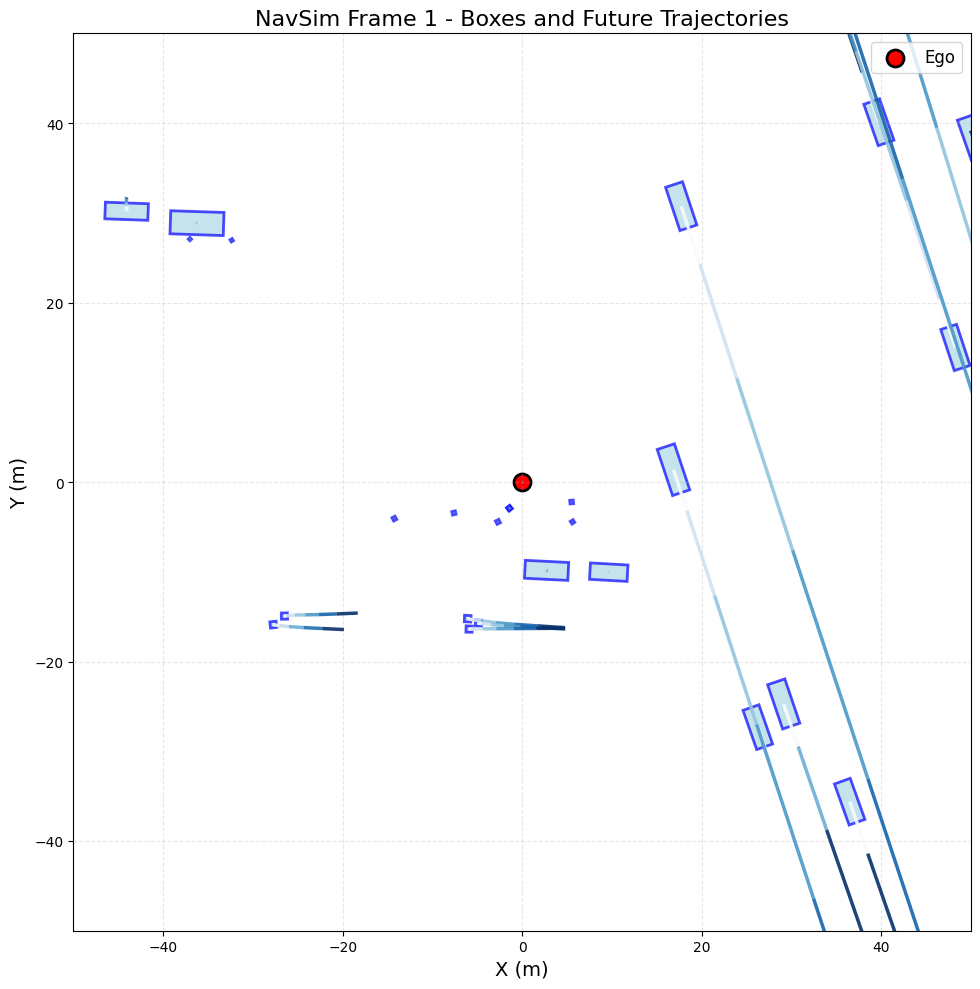

Visualization saved as 'simple_navsim_visualization.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.patches import Polygon

def offsets_to_positions(offsets, start=np.zeros(2)):
    """Convert step offsets to cumulative positions."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cum = np.vstack([np.zeros(2), np.cumsum(offsets, axis=0)])
    return cum + start

def plot_gradient_trajectory(ax, traj_xy, color='blue', linewidth=2, alpha=0.8):
    """Plot trajectory with time-based gradient."""
    traj_xy = np.asarray(traj_xy, dtype=np.float32)
    if len(traj_xy) < 2:
        return

    points = traj_xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=color, linewidth=linewidth, alpha=alpha)
    lc.set_array(np.linspace(0, 1, len(segments)))
    ax.add_collection(lc)

def box_corners_2d(center_xy, length, width, yaw_rad):
    """Calculate 2D box corners."""
    x, y = center_xy
    dx = length / 2.0
    dy = width / 2.0

    corners = np.array([
        [ dx,  dy],  # front-right
        [ dx, -dy],  # front-left
        [-dx, -dy],  # rear-left
        [-dx,  dy]   # rear-right
    ])

    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]])
    rotated = corners @ rot.T
    return rotated + np.array([x, y])

def simple_visualization(navsim_infos, frame_idx=0):
    """Simple visualization with boxes and future trajectories only."""
    info = navsim_infos['infos'][frame_idx]
    fut_ts = info['gt_agent_fut_trajs'].shape[-1] // 2

    # Ego trajectories
    ego_hist = offsets_to_positions(info['gt_ego_his_trajs'])
    ego_fut = offsets_to_positions(info['gt_ego_fut_trajs'])

    # Agent data
    boxes = info['gt_boxes']
    agent_centers = boxes[:, :2]
    agent_yaws = boxes[:, 6]
    agent_lengths = boxes[:, 3]
    agent_widths = boxes[:, 4]
    agent_fut_offsets = info['gt_agent_fut_trajs'].reshape(-1, fut_ts, 2)
    agent_fut_masks = info['gt_agent_fut_masks']

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'NavSim Frame {frame_idx} - Boxes and Future Trajectories', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Plot ego
    ax.scatter(0, 0, c='red', s=150, label='Ego', marker='o', edgecolor='black', linewidth=2)
    plot_gradient_trajectory(ax, ego_hist, color='Greys', linewidth=3, alpha=0.7)
    plot_gradient_trajectory(ax, ego_fut, color='Reds', linewidth=3, alpha=0.9)

    # Plot agents
    for i, (center, yaw, length, width, fut_off, mask) in enumerate(zip(
        agent_centers, agent_yaws, agent_lengths, agent_widths,
        agent_fut_offsets, agent_fut_masks)):

        # Plot box
        corners = box_corners_2d(center, length, width, yaw)
        poly = Polygon(corners, closed=True, facecolor='lightblue',
                      edgecolor='blue', linewidth=2, alpha=0.7)
        ax.add_patch(poly)

        # Plot future trajectory
        valid_steps = mask.astype(bool)
        if valid_steps.any():
            fut_traj = offsets_to_positions(fut_off[valid_steps], start=center)
            plot_gradient_trajectory(ax, fut_traj, color='Blues', linewidth=2.5, alpha=0.9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.legend(fontsize=12)
    plt.tight_layout()
    return fig

# Main execution
if __name__ == "__main__":
    # Load data
    with open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl', 'rb') as fp:
        navsim_infos = pickle.load(fp)

    # Create simple visualization
    fig = simple_visualization(navsim_infos, frame_idx=0)
    plt.show()

    # Save figure
    plt.savefig('simple_navsim_visualization.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'simple_navsim_visualization.png'")

In [ ]:
# Main execution
if __name__ == "__main__":
    # Load data
    with open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl', 'rb') as fp:
        navsim_infos = pickle.load(fp)

    # Create simple visualization
    fig = simple_visualization(navsim_infos, frame_idx=0)
    plt.show()

    # Save figure
    plt.savefig('simple_navsim_visualization.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'simple_navsim_visualization.png'")




In [23]:
navsim_infos.keys()

dict_keys(['infos', 'metadata'])

Loaded dataset with 349 frames
Creating video from 349 frames...


KeyboardInterrupt: 

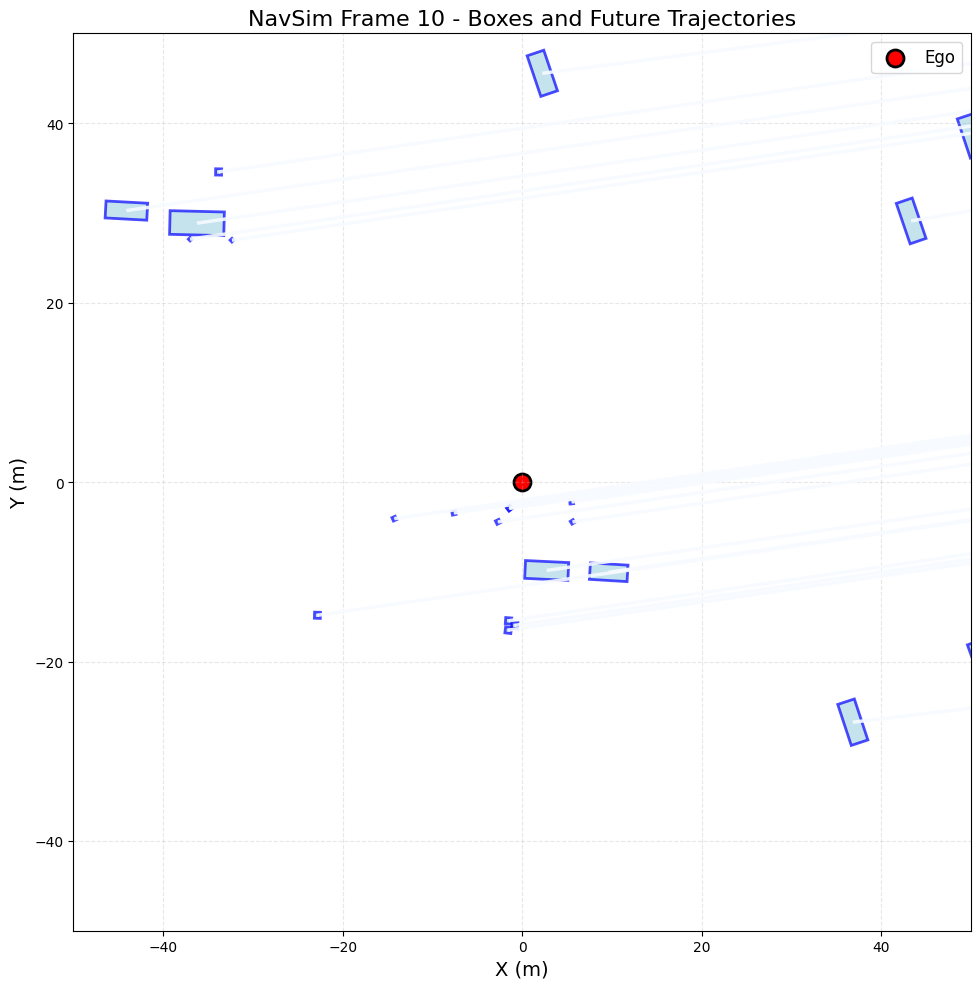

In [48]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.patches import Polygon

def offsets_to_positions(offsets, start=np.zeros(2)):
    """Convert step offsets to cumulative positions."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cum = np.vstack([np.zeros(2), np.cumsum(offsets, axis=0)])
    return cum + start

def plot_gradient_trajectory(ax, traj_xy, color='blue', linewidth=2, alpha=0.8):
    """Plot trajectory with time-based gradient."""
    traj_xy = np.asarray(traj_xy, dtype=np.float32)
    if len(traj_xy) < 2:
        return

    points = traj_xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=color, linewidth=linewidth, alpha=alpha)
    lc.set_array(np.linspace(0, 1, len(segments)))
    ax.add_collection(lc)

def box_corners_2d(center_xy, length, width, yaw_rad):
    """Calculate 2D box corners."""
    x, y = center_xy
    dx = length / 2.0
    dy = width / 2.0

    corners = np.array([
        [ dx,  dy],  # front-right
        [ dx, -dy],  # front-left
        [-dx, -dy],  # rear-left
        [-dx,  dy]   # rear-right
    ])

    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]])
    rotated = corners @ rot.T
    return rotated + np.array([x, y])

def simple_visualization(navsim_infos, frame_idx=0):
    """Simple visualization with boxes and future trajectories only."""
    info = navsim_infos['infos'][frame_idx]
    fut_ts = info['gt_agent_fut_trajs'].shape[-1] // 2

    # Ego trajectories
    ego_hist = offsets_to_positions(info['gt_ego_his_trajs'])
    ego_fut = offsets_to_positions(info['gt_ego_fut_trajs'])

    # Agent data
    boxes = info['gt_boxes']
    agent_centers = boxes[:, :2]
    agent_yaws = boxes[:, 6]
    agent_lengths = boxes[:, 3]
    agent_widths = boxes[:, 4]
    agent_fut_offsets = info['gt_agent_fut_trajs'].reshape(-1, fut_ts, 2)
    agent_fut_masks = info['gt_agent_fut_masks']

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'NavSim Frame {frame_idx} - Boxes and Future Trajectories', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Plot ego
    ax.scatter(0, 0, c='red', s=150, label='Ego', marker='o', edgecolor='black', linewidth=2)
    plot_gradient_trajectory(ax, ego_hist, color='Greys', linewidth=3, alpha=0.7)
    plot_gradient_trajectory(ax, ego_fut, color='Reds', linewidth=3, alpha=0.9)

    # Plot agents
    for i, (center, yaw, length, width, fut_off, mask) in enumerate(zip(
        agent_centers, agent_yaws, agent_lengths, agent_widths,
        agent_fut_offsets, agent_fut_masks)):

        # Plot box
        corners = box_corners_2d(center, length, width, yaw)
        poly = Polygon(corners, closed=True, facecolor='lightblue',
                      edgecolor='blue', linewidth=2, alpha=0.7)
        ax.add_patch(poly)

        # Plot future trajectory
        valid_steps = mask.astype(bool)
        if valid_steps.any():
            fut_traj = offsets_to_positions(fut_off[valid_steps], start=center)
            plot_gradient_trajectory(ax, fut_traj, color='Blues', linewidth=2.5, alpha=0.9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.legend(fontsize=12)
    plt.tight_layout()
    return fig

def create_video_from_frames(navsim_infos, output_filename='navsim_visualization.mp4', fps=2):
    """Create video from all frames in the dataset."""
    import imageio
    import io

    num_frames = len(navsim_infos['infos'])
    print(f"Creating video from {num_frames} frames...")

    frames = []

    for frame_idx in range(num_frames):
        print(f"Processing frame {frame_idx + 1}/{num_frames}", end='\r')

        # Create visualization for current frame
        fig = simple_visualization(navsim_infos, frame_idx)

        # Convert matplotlib figure to image
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)

        # Read image and add to frames
        img = imageio.imread(buf)
        frames.append(img)

        # Close figure to save memory
        plt.close(fig)
        buf.close()

    # Save video
    print(f"\nSaving video to {output_filename}...")
    imageio.mimsave(output_filename, frames, fps=fps)
    print(f"Video saved successfully! ({len(frames)} frames at {fps} fps)")

# Main execution
if __name__ == "__main__":
    # Load data
    with open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl', 'rb') as fp:
        navsim_infos = pickle.load(fp)

    print(f"Loaded dataset with {len(navsim_infos['infos'])} frames")

    # Create video from all frames
    create_video_from_frames(navsim_infos, 'navsim_scene_visualization.mp4', fps=2)

    # # Also create single frame visualization for reference
    # fig = simple_visualization(navsim_infos, frame_idx=0)
    # plt.savefig('navsim_frame_sample.png', dpi=150, bbox_inches='tight')
    # plt.show()
    # print("Sample frame saved as 'navsim_frame_sample.png'")

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.patches import Polygon

def offsets_to_positions(offsets, start=np.zeros(2)):
    """Convert step offsets to cumulative positions."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cum = np.vstack([np.zeros(2), np.cumsum(offsets, axis=0)])
    return cum + start

def plot_gradient_trajectory(ax, traj_xy, color='blue', linewidth=2, alpha=0.8):
    """Plot trajectory with time-based gradient."""
    traj_xy = np.asarray(traj_xy, dtype=np.float32)
    if len(traj_xy) < 2:
        return

    points = traj_xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=color, linewidth=linewidth, alpha=alpha)
    lc.set_array(np.linspace(0, 1, len(segments)))
    ax.add_collection(lc)

def box_corners_2d(center_xy, length, width, yaw_rad):
    """Calculate 2D box corners."""
    x, y = center_xy
    dx = length / 2.0
    dy = width / 2.0

    corners = np.array([
        [ dx,  dy],  # front-right
        [ dx, -dy],  # front-left
        [-dx, -dy],  # rear-left
        [-dx,  dy]   # rear-right
    ])

    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]])
    rotated = corners @ rot.T
    return rotated + np.array([x, y])

def simple_visualization(navsim_infos, frame_idx=0):
    """Simple visualization with boxes and future trajectories only."""
    info = navsim_infos['infos'][frame_idx]
    fut_ts = info['gt_agent_fut_trajs'].shape[-1] // 2

    # Ego trajectories
    ego_hist = offsets_to_positions(info['gt_ego_his_trajs'])
    ego_fut = offsets_to_positions(info['gt_ego_fut_trajs'])

    # Agent data
    boxes = info['gt_boxes']
    agent_centers = boxes[:, :2]
    agent_yaws = boxes[:, 6]
    agent_lengths = boxes[:, 3]
    agent_widths = boxes[:, 4]
    agent_fut_offsets = info['gt_agent_fut_trajs'].reshape(-1, fut_ts, 2)
    agent_fut_masks = info['gt_agent_fut_masks']

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(f'NavSim Frame {frame_idx} - Boxes and Future Trajectories', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Plot ego
    ax.scatter(0, 0, c='red', s=150, label='Ego', marker='o', edgecolor='black', linewidth=2)
    plot_gradient_trajectory(ax, ego_hist, color='Greys', linewidth=3, alpha=0.7)
    plot_gradient_trajectory(ax, ego_fut, color='Reds', linewidth=3, alpha=0.9)

    # Plot agents
    for i, (center, yaw, length, width, fut_off, mask) in enumerate(zip(
        agent_centers, agent_yaws, agent_lengths, agent_widths,
        agent_fut_offsets, agent_fut_masks)):

        # Plot box
        corners = box_corners_2d(center, length, width, yaw)
        poly = Polygon(corners, closed=True, facecolor='lightblue',
                      edgecolor='blue', linewidth=2, alpha=0.7)
        ax.add_patch(poly)

        # Plot future trajectory
        valid_steps = mask.astype(bool)
        if valid_steps.any():
            fut_traj = offsets_to_positions(fut_off[valid_steps], start=center)
            plot_gradient_trajectory(ax, fut_traj, color='Blues', linewidth=2.5, alpha=0.9)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.legend(fontsize=12)
    plt.tight_layout()
    return fig

def create_video_from_frames(navsim_infos, output_filename='navsim_visualization.mp4', fps=2, max_len=None):
    """
    Create video from frames in the dataset.

    Args:
        navsim_infos: NavSim dataset information.
        output_filename: Output video filename.
        fps: Frames per second for the video.
        max_len: Maximum number of frames to process (None for all frames).
    """
    import imageio
    import io

    total_frames = len(navsim_infos['infos'])
    num_frames = min(total_frames, max_len) if max_len is not None else total_frames

    print(f"Creating video from {num_frames} frames (total available: {total_frames})...")

    frames = []

    for frame_idx in range(num_frames):
        print(f"Processing frame {frame_idx + 1}/{num_frames}", end='\r')

        # Create visualization for current frame
        fig = simple_visualization(navsim_infos, frame_idx)

        # Convert matplotlib figure to image
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)

        # Read image and add to frames
        img = imageio.imread(buf)
        frames.append(img)

        # Close figure to save memory
        plt.close(fig)
        buf.close()

    # Save video
    print(f"\nSaving video to {output_filename}...")
    imageio.mimsave(output_filename, frames, fps=fps)
    print(f"Video saved successfully! ({len(frames)} frames at {fps} fps)")

# Main execution
if __name__ == "__main__":
    # Load data
    with open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl', 'rb') as fp:
        navsim_infos = pickle.load(fp)

    print(f"Loaded dataset with {len(navsim_infos['infos'])} frames")

    # Create video from limited frames (example: first 50 frames)
    # For all frames, set max_len=None or remove the parameter

    # Alternative: Create video from all frames
    # create_video_from_frames(navsim_infos, 'navsim_scene_full.mp4', fps=2)

    # Also create single frame visualization for reference
    # fig = simple_visualization(navsim_infos, frame_idx=0)
    # plt.savefig('navsim_frame_sample.png', dpi=150, bbox_inches='tight')
    # plt.show()
    # print("Sample frame saved as 'navsim_frame_sample.png'")

Loaded dataset with 349 frames


In [2]:
create_video_from_frames(navsim_infos, 'navsim_scene_2.mp4', fps=2, max_len=50)

Creating video from 50 frames (total available: 349)...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (980, 989) to (992, 992) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).



Saving video to navsim_scene_2.mp4...


[rawvideo @ 0x70d3c00] Stream #0: not enough frames to estimate rate; consider increasing probesize


Video saved successfully! (50 frames at 2 fps)


Loaded dataset with 349 frames
ego_fut_trajs shape: (7, 2)
agent_fut_trajs shape: (56, 16)
ego_fut_trajs: [[ 5.7602148e-05 -4.1281521e-05]
 [ 2.2387452e-05  8.1277976e-06]
 [ 1.1411135e-04 -2.0105501e-05]]
agent_fut_trajs[0]: [[  21.762875     3.1613994]
 [-178.52347    -25.848095 ]
 [ -14.405353    -2.0783935]]


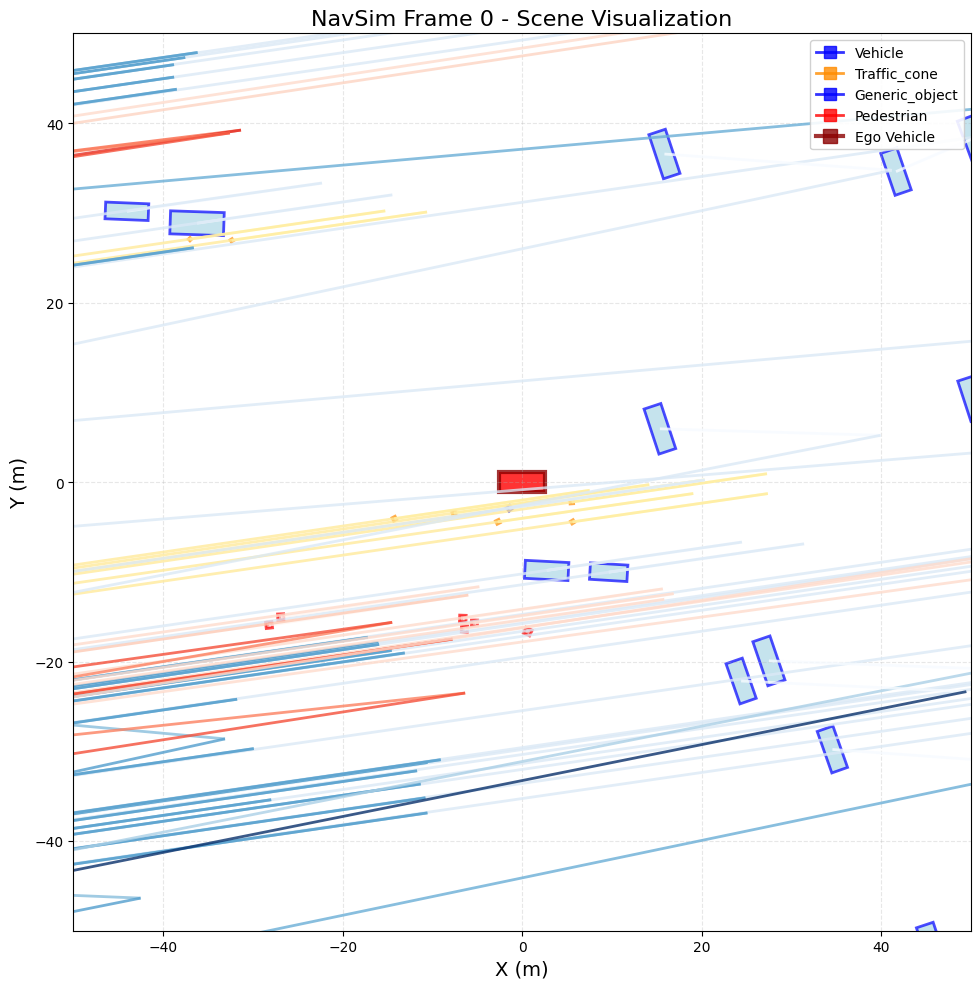

Sample frame saved as 'navsim_frame_sample.png'


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib.patches import Polygon

def offsets_to_positions(offsets, start=np.zeros(2)):
    """Convert step offsets to cumulative positions."""
    offsets = np.asarray(offsets, dtype=np.float32)
    if offsets.ndim == 1:
        offsets = offsets.reshape(-1, 2)
    cum = np.vstack([np.zeros(2), np.cumsum(offsets, axis=0)])
    return cum + start

def plot_gradient_trajectory(ax, traj_xy, color='blue', linewidth=2, alpha=0.8):
    """Plot trajectory with time-based gradient."""
    traj_xy = np.asarray(traj_xy, dtype=np.float32)
    if len(traj_xy) < 2:
        return

    points = traj_xy.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=color, linewidth=linewidth, alpha=alpha)
    lc.set_array(np.linspace(0, 1, len(segments)))
    ax.add_collection(lc)

def box_corners_2d(center_xy, length, width, yaw_rad):
    """Calculate 2D box corners."""
    x, y = center_xy
    dx = length / 2.0
    dy = width / 2.0

    corners = np.array([
        [ dx,  dy],  # front-right
        [ dx, -dy],  # front-left
        [-dx, -dy],  # rear-left
        [-dx,  dy]   # rear-right
    ])

    c, s = np.cos(yaw_rad), np.sin(yaw_rad)
    rot = np.array([[c, -s], [s, c]])
    rotated = corners @ rot.T
    return rotated + np.array([x, y])

def simple_visualization(navsim_infos, frame_idx=0, figsize=(12, 10)):
    """Fixed visualization - agent trajectories are ALREADY in ego coordinates."""
    info = navsim_infos['infos'][frame_idx]
    fut_ts = info['gt_agent_fut_trajs'].shape[-1] // 2

    # Debug: trajectory 값 확인
    print(f"ego_fut_trajs: {info['gt_ego_fut_trajs'][:3] if len(info['gt_ego_fut_trajs']) > 0 else 'empty'}")
    if len(info['gt_agent_fut_trajs']) > 0:
        agent_sample = info['gt_agent_fut_trajs'][0].reshape(-1, 2)
        print(f"agent_fut_trajs[0]: {agent_sample[:3]}")

    # Ego trajectories (offset 기반)
    ego_hist = offsets_to_positions(info['gt_ego_his_trajs'])
    ego_fut = offsets_to_positions(info['gt_ego_fut_trajs'])

    # Agent data - 이미 ego-relative coordinates
    boxes = info['gt_boxes']
    agent_names = info['gt_names']
    agent_centers = boxes[:, :2]
    agent_yaws = boxes[:, 6]
    agent_lengths = boxes[:, 3]
    agent_widths = boxes[:, 4]
    agent_fut_offsets = info['gt_agent_fut_trajs'].reshape(-1, fut_ts, 2)
    agent_fut_masks = info['gt_agent_fut_masks']

    # Color mapping for different classes
    class_colors = {
        'vehicle': {'face': 'lightblue', 'edge': 'blue', 'traj': 'Blues'},
        'pedestrian': {'face': 'lightcoral', 'edge': 'red', 'traj': 'Reds'},
        'bicycle': {'face': 'lightgreen', 'edge': 'green', 'traj': 'Greens'},
        'motorcycle': {'face': 'lightyellow', 'edge': 'orange', 'traj': 'Oranges'},
        'bus': {'face': 'lightpink', 'edge': 'purple', 'traj': 'Purples'},
        'trailer': {'face': 'lightgray', 'edge': 'gray', 'traj': 'Greys'},
        'construction_vehicle': {'face': 'lightsalmon', 'edge': 'brown', 'traj': 'copper'},
        'traffic_cone': {'face': 'khaki', 'edge': 'darkorange', 'traj': 'YlOrRd'},
        'barrier': {'face': 'lightsteelblue', 'edge': 'navy', 'traj': 'Blues'},
        'default': {'face': 'lightblue', 'edge': 'blue', 'traj': 'Blues'}
    }

    # Create plot with adjustable size
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'NavSim Frame {frame_idx} - Scene Visualization', fontsize=16)
    ax.set_xlabel('X (m)', fontsize=14)
    ax.set_ylabel('Y (m)', fontsize=14)
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)

    # Plot ego vehicle as a box
    ego_length, ego_width = 5.176, 2.297  # Pacifica dimensions
    ego_corners = box_corners_2d([0, 0], ego_length, ego_width, 0)  # Ego at origin, facing forward
    ego_poly = Polygon(ego_corners, closed=True, facecolor='red',
                      edgecolor='darkred', linewidth=3, alpha=0.8)
    ax.add_patch(ego_poly)

    # Plot ego trajectories (no legend entries)
    if len(ego_hist) > 1:
        plot_gradient_trajectory(ax, ego_hist, color='YlOrBr', linewidth=3, alpha=0.8)

    if len(ego_fut) > 1:
        plot_gradient_trajectory(ax, ego_fut, color='Greens', linewidth=3, alpha=0.9)

    # Track which classes we've seen for legend
    classes_seen = set()

    # Plot agents with class-based colors
    for i, (name, center, yaw, length, width, fut_off, mask) in enumerate(zip(
        agent_names, agent_centers, agent_yaws, agent_lengths, agent_widths,
        agent_fut_offsets, agent_fut_masks)):

        # Get colors for this class
        colors = class_colors.get(name, class_colors['default'])

        # Plot box
        corners = box_corners_2d(center, length, width, yaw)
        poly = Polygon(corners, closed=True,
                      facecolor=colors['face'],
                      edgecolor=colors['edge'],
                      linewidth=2, alpha=0.7)
        ax.add_patch(poly)

        # Plot future trajectory
        valid_steps = mask.astype(bool)
        if valid_steps.any():
            fut_traj = offsets_to_positions(fut_off[valid_steps], start=center)
            plot_gradient_trajectory(ax, fut_traj, color=colors['traj'], linewidth=2, alpha=0.8)

        # Add to legend only once per class
        if name not in classes_seen:
            ax.plot([], [], color=colors['edge'], linewidth=2,
                   label=f'{name.capitalize()}', alpha=0.8, marker='s', markersize=8)
            classes_seen.add(name)

    # Add ego to legend (only the vehicle box)
    ax.plot([], [], color='darkred', linewidth=3, label='Ego Vehicle',
           alpha=0.8, marker='s', markersize=10)

    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    ax.legend(fontsize=10, loc='upper right', framealpha=0.9)  # Fixed to upper right
    plt.tight_layout()
    return fig

def create_video_from_frames(navsim_infos, output_filename='navsim_visualization.mp4', fps=2, max_len=None,
                           fast_render=False, dpi=100, figsize=(12, 10)):
    """
    Create video from frames in the dataset.

    Args:
        navsim_infos: NavSim dataset information.
        output_filename: Output video filename.
        fps: Frames per second for the video.
        max_len: Maximum number of frames to process (None for all frames).
        fast_render: If True, use lower quality for faster rendering.
        dpi: DPI for rendering (lower = faster, higher = better quality).
        figsize: Figure size tuple (width, height) in inches.
    """
    import imageio
    import io

    # Adjust rendering settings for speed
    if fast_render:
        dpi = 50  # Very low DPI for speed
        figsize = (8, 6)  # Smaller figure size
        print("Fast render mode: Using low DPI and small figure size for speed")

    total_frames = len(navsim_infos['infos'])
    num_frames = min(total_frames, max_len) if max_len is not None else total_frames

    print(f"Creating video from {num_frames} frames (total available: {total_frames})")
    print(f"Render settings: DPI={dpi}, figsize={figsize}")

    frames = []

    for frame_idx in range(num_frames):
        print(f"Processing frame {frame_idx + 1}/{num_frames}", end='\r')

        # Create visualization for current frame with custom settings
        fig = simple_visualization(navsim_infos, frame_idx, figsize=figsize)

        # Convert matplotlib figure to image with fixed pixel size
        buf = io.BytesIO()
        # Use fixed pixel dimensions instead of bbox_inches='tight' for consistency
        fig.set_size_inches(figsize[0], figsize[1])
        fig.savefig(buf, format='png', dpi=dpi, facecolor='white')
        buf.seek(0)

        # Read image and add to frames
        img = imageio.imread(buf)
        frames.append(img)

        # Close figure to save memory
        plt.close(fig)
        buf.close()

    # Save video
    print(f"\nSaving video to {output_filename}...")
    imageio.mimsave(output_filename, frames, fps=fps)
    print(f"Video saved successfully! ({len(frames)} frames at {fps} fps)")

# Main execution
if __name__ == "__main__":
    # Load data
    with open('data/navsim_infos/vad_navsim_infos_temporal_val_start0_count1.pkl', 'rb') as fp:
        navsim_infos = pickle.load(fp)

    print(f"Loaded dataset with {len(navsim_infos['infos'])} frames")

    # Check trajectory format from first frame
    info = navsim_infos['infos'][0]
    print(f"ego_fut_trajs shape: {info['gt_ego_fut_trajs'].shape}")
    print(f"agent_fut_trajs shape: {info['gt_agent_fut_trajs'].shape}")

    # Example 1: Fast render mode
    # create_video_from_frames(navsim_infos, 'navsim_fast.mp4', fps=3, max_len=50, fast_render=True)

    # Example 2: Custom settings
    # create_video_from_frames(navsim_infos, 'navsim_custom.mp4', fps=2, max_len=100, dpi=75, figsize=(10, 8))

    # Example 3: High quality (slow)
    # create_video_from_frames(navsim_infos, 'navsim_hq.mp4', fps=2, max_len=20, dpi=150, figsize=(14, 12))

    # Also create single frame visualization for reference
    fig = simple_visualization(navsim_infos, frame_idx=0)
    plt.savefig('navsim_frame_sample.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Sample frame saved as 'navsim_frame_sample.png'")